# 00. Homework description

For this assignment, your task is to develop the [FastPitch](https://arxiv.org/abs/2006.06873) synthesis model, train it, and generate several audio samples.

The training and data processing code has already been provided for you. The training will be conducted on the LJspeech dataset.

The total score for the homework is **10 points**, distributed as follows:
- 1 point for visualizing the input data
- 8 points for writing the model code and running training
- 1 point for pitch and duration manipulations during inference

The homework submission **should include**:
- Completed notebook
- Attached WER and loss graphs from TensorBoard
- 1 audio file - the result of a regular model inference
- 4 additional audio files: you are encouraged to experiment with adjusting phoneme durations and pitch slightly and listen to the results.

# 01. Preparation steps

In [142]:
device = "cuda"
gpu_avaiable = "1"    

In [143]:
path_to_sources = "/home/kolya/speech_course/week_08_tts_am_vocoders" 

### Dataset

We will work with [LJSpeech](https://keithito.com/LJ-Speech-Dataset/) -- a single-speaker dataset with 24 hours of speech.

The data we will use contains pre-computed [MFA-alignments](https://montreal-forced-aligner.readthedocs.io/en/latest/user_guide/workflows/alignment.html) alongside with the original wavs and texts. If you are interested in the process of extracting such alignments, please refer to this [tutorial](https://colab.research.google.com/gist/NTT123/12264d15afad861cb897f7a20a01762e/mfa-ljspeech.ipynb).

Download the dataset with precomputed alignments.

In [144]:
path_to_dataset = '/home/kolya/speech_course/week_08_tts_am_vocoders/dataset'  

In [145]:
# import requests
# from urllib.parse import urlencode
# from io import BytesIO
# from zipfile import ZipFile

# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# public_key = 'https://disk.yandex.ru/d/PpgePfWcQTAbug'

# final_url = base_url + urlencode(dict(public_key=public_key))
# response = requests.get(final_url)
# download_url = response.json()['href']
# response = requests.get(download_url)


# zipfile = ZipFile(BytesIO(response.content))
# zipfile.extractall(path=path_to_dataset)

### Hi-Fi GAN checkpoint


Download a pretrained Hi-Fi GAN checkpoint (to generate audio from the predicted mel-spectrograms).

In [146]:
# !wget --content-disposition https://api.ngc.nvidia.com/v2/models/nvidia/dle/hifigan__pyt_ckpt_ds-ljs22khz/versions/21.08.0_amp/zip -O hifigan_ckpt.zip
# !unzip hifigan_ckpt.zip
# !rm hifigan_ckpt.zip

In [147]:
path_to_hfg_ckpt = "hifigan_gen_checkpoint_6500.pt" 

### Imports

In [148]:
import sys
import os
import json
import dataclasses
import torch
import subprocess as sp
import matplotlib.pylab as plt
import soundfile as sf
import numpy as np
import nltk
nltk.download('averaged_perceptron_tagger')

from g2p_en import G2p
import IPython.display as Ipd

import torch
from torch import nn as nn

sys.path.append(path_to_sources)

from sources.fastpitch.common.checkpointer import Checkpointer
from sources.fastpitch.model import FastPitch
from sources.fastpitch.data import FastPitchBatch, SymbolsSet
from sources.hifigan.model import load_model as load_hfg_model

from sources.fastpitch.hparams import HParamsFastpitch
from sources.fastpitch.data import prepare_loaders
from sources.fastpitch.common.layers import TemporalPredictor
from sources.fastpitch.common.utils import DeviceGetterMixin
from sources.fastpitch.common.utils import regulate_len
from sources.fastpitch.data import FastPitchBatch, SymbolsSet
from sources.fastpitch.hparams import HParamsFastpitch
from sources.fastpitch.common.transformer import FFTransformer

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/kolya/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# 02. See a data sample (1 point)

The mfa alignment provides phonemes and their durations, which we will need during training:

In [149]:
with open(os.path.join(path_to_dataset, 'mfa_aligned', 'LJ001-0001.json')) as f:
  utterance = json.load(f)

utterance

{'start': 0,
 'end': 9.655062,
 'tiers': {'words': {'type': 'interval',
   'entries': [[0.0, 0.69, 'printing'],
    [0.69, 0.82, '<eps>'],
    [0.82, 1.01, 'in'],
    [1.01, 1.15, 'the'],
    [1.15, 1.45, 'only'],
    [1.45, 1.97, 'sense'],
    [1.97, 2.14, 'with'],
    [2.14, 2.39, 'which'],
    [2.39, 2.54, 'we'],
    [2.54, 2.71, 'are'],
    [2.71, 2.89, 'at'],
    [2.89, 3.28, 'present'],
    [3.28, 4.0, 'concerned'],
    [4.0, 4.41, '<eps>'],
    [4.41, 5.01, 'differs'],
    [5.01, 5.04, '<eps>'],
    [5.04, 5.28, 'from'],
    [5.28, 5.65, 'most'],
    [5.65, 5.82, 'if'],
    [5.82, 6.1, 'not'],
    [6.1, 6.29, 'from'],
    [6.29, 6.63, 'all'],
    [6.63, 6.78, 'the'],
    [6.78, 7.09, 'arts'],
    [7.09, 7.22, 'and'],
    [7.22, 7.8, 'crafts'],
    [7.8, 8.45, 'represented'],
    [8.45, 8.66, 'in'],
    [8.66, 8.79, 'the'],
    [8.79, 9.6, 'exhibition'],
    [9.6, 9.655062, '<eps>']]},
  'phones': {'type': 'interval',
   'entries': [[0.0, 0.04, 'P'],
    [0.04, 0.07, 'R'],
    [0

Phoneme `sil` here denotes pause -- a period of silence between spoken phonemes. The phonemes are from [ARPA](https://en.wikipedia.org/wiki/ARPABET) alphabet.

In [150]:
hparams = HParamsFastpitch()
train_loader, val_loader = prepare_loaders(path_to_dataset, hparams)

In [151]:
train_iter = iter(train_loader)
batch = next(train_iter)

In [152]:
list(dataclasses.asdict(batch).keys())

['texts',
 'text_lengths',
 'mels',
 'mel_lengths',
 'pitches',
 'durations',
 'paces']

In [153]:
batch.mels.shape
# print(batch.mels[0][0])

torch.Size([13, 80, 830])

In [154]:
batch.pitches.shape
# print(batch.pitches[0])

torch.Size([13, 103])

In [155]:
batch.durations.shape
# print(batch.durations[0])

torch.Size([13, 103])

## Task

**(0.5 points)** Draw a combined image showing both the mel-spectrogram and pitch for a sample from the batch. Use durations to ensure proper alignment of their shapes in the image.  
**(0.5 points)** Include phoneme labels near the time axis on the image from the previous step. (like in Figure 3 in the [paper](https://arxiv.org/pdf/2006.06873.pdf)). You may find the code from the seminar helpful.

In [156]:
import librosa

localCymbolSet = SymbolsSet()
minFreq = 0
maxFreq = 8000

def plot_graphics(number:int) -> None:
    text_len = batch.text_lengths[number]
    mel_len = batch.mel_lengths[number]

    mel = batch.mels[number, :, :mel_len]
    text = batch.texts[number, :text_len]
    pitches = batch.pitches[number, :text_len]
    durations = batch.durations[number, :text_len]

    scale = 62.51305    
    mean = 215.42230
    pitchRestore = (pitches * scale + mean).cpu().numpy()
    durations = np.hstack([[0], durations.cpu().numpy().cumsum()])

    mel_centers = librosa.mel_frequencies(n_mels=mel.shape[0], fmin=minFreq, fmax=maxFreq) 
    filters = np.array([np.argmin(np.abs(mel_centers - f0)) for f0 in pitchRestore])   

    phonemes = localCymbolSet.decode(text.tolist())
    _, ax = plt.subplots(figsize=(30, 20))
    ax.imshow(mel, origin='lower')
    
    for i, curFilter in enumerate(filters):
        start, end = durations[i], durations[i+1]
        ax.hlines(y=curFilter, xmin=start, xmax=end, colors='r')

    for i, s in enumerate(durations[:-1]):
        shift = -5 if i % 2 else -15
        ax.text(s, shift * ax.get_ylim()[0], phonemes[i], fontsize=7, weight="bold")

    for curX in durations:
        ax.axvline(x=curX, c='r')

    plt.show()

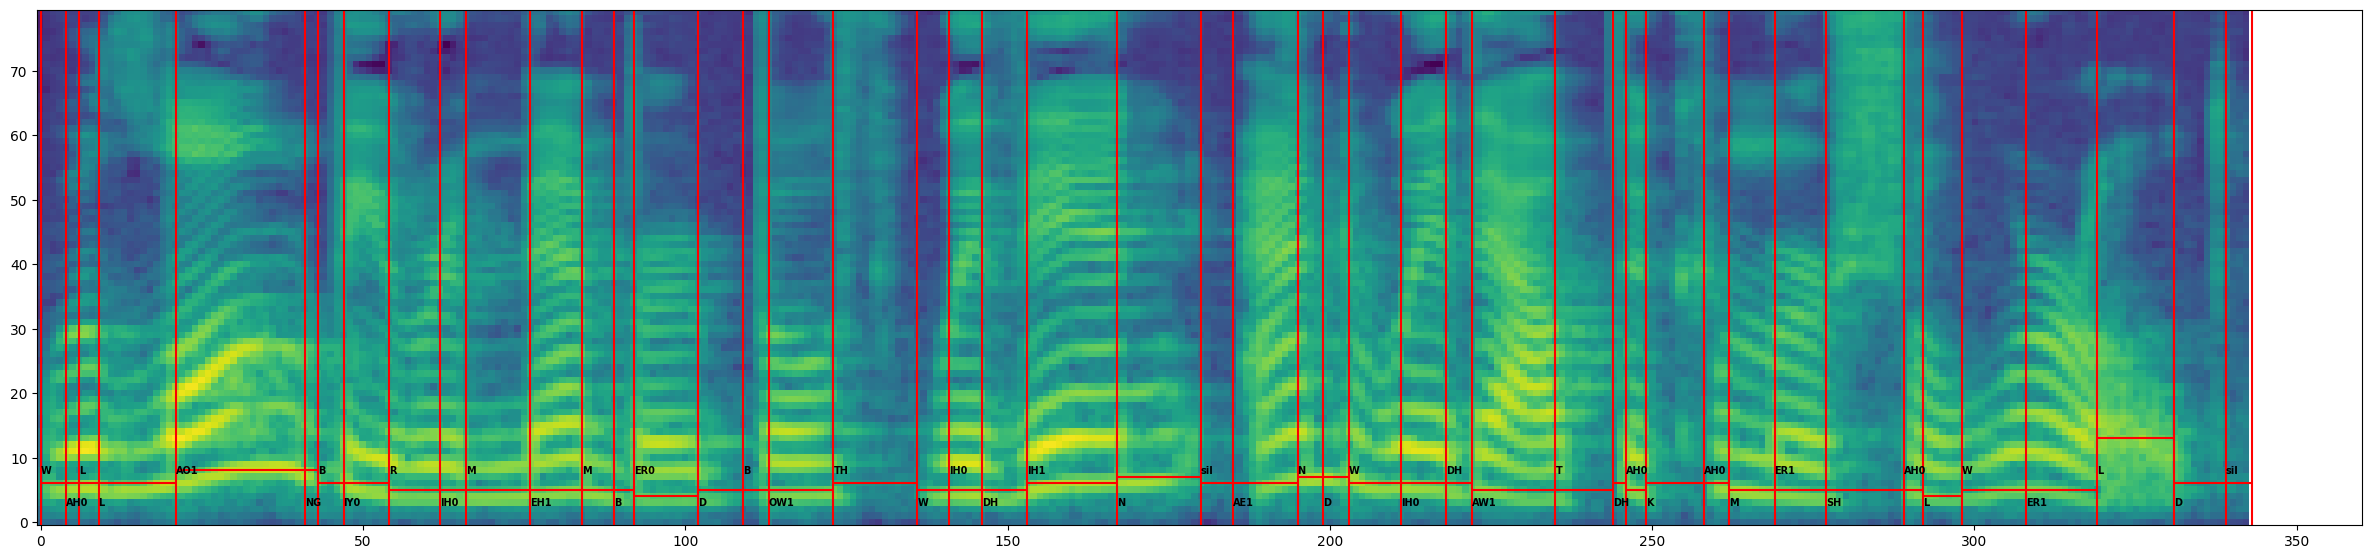

In [157]:
plot_graphics(0)

# 03. Implement FastPitch model (9 points)

Please implement the FastPitch model in the cell provided below. Running this cell will overwrite the model file in the repository. 
- Run training (see next cells)
- Run inference (see next cells)
- When submitting the homework, please include
   - the Word Error Rate (WER) and loss curves obtained from TensorBoard as attachments,
   - the generated audio (see inference cells). If attaching an archive, use the name: `prediction.wav`

By the end of training, the loss should reach approximately 0.69, and WER should be close to zero (around 0.006). The training process will take about 30 minutes (3,000 batches).

**Important:** By the end of the training, the generated audio sample must be clear in terms of speech (WER close to 0) and maintain audio quality comparable to the original recordings (as logged in TensorBoard). **If these conditions are not met, the entire section will receive zero points**, regardless of how closely the model code resembles working code. Here is an example of how an audio from a well-trained model may sound:

In [158]:
audio, sr = sf.read('prediction_example.wav')
Ipd.display(Ipd.Audio(audio, rate=sr))

In [159]:
%%writefile /home/kolya/speech_course/week_08_tts_am_vocoders/sources/fastpitch/model.py
import torch
from torch import nn as nn

from sources.fastpitch.common.layers import TemporalPredictor
from sources.fastpitch.common.utils import DeviceGetterMixin
from sources.fastpitch.common.utils import regulate_len
from sources.fastpitch.data import FastPitchBatch, SymbolsSet
from sources.fastpitch.hparams import HParamsFastpitch
from sources.fastpitch.common.transformer import FFTransformer

class FastPitch(nn.Module, DeviceGetterMixin):
    def __init__(self, hparams: HParamsFastpitch):
        super().__init__()
        self.hparams = hparams
        n_symbols = len(SymbolsSet().symbols_to_id)

        self.symbol_emb = nn.Embedding(n_symbols, hparams.symbols_embedding_dim)

        self.encoder = FFTransformer(
            n_layer=hparams.in_fft_n_layers,
            n_head=hparams.in_fft_n_heads,
            d_model=hparams.symbols_embedding_dim,
            d_head=hparams.in_fft_d_head,
            d_inner=4 * hparams.symbols_embedding_dim,
            kernel_size=hparams.in_fft_conv1d_kernel_size,
            dropout=hparams.p_in_fft_dropout,
            dropatt=hparams.p_in_fft_dropatt,
            dropemb=hparams.p_in_fft_dropemb
        )

        self.duration_predictor = TemporalPredictor(
            input_size=hparams.symbols_embedding_dim,
            filter_size=hparams.dur_predictor_filter_size,
            kernel_size=hparams.dur_predictor_kernel_size,
            dropout=hparams.p_dur_predictor_dropout,
            n_layers=hparams.dur_predictor_n_layers
        )

        self.pitch_predictor = TemporalPredictor(
            input_size=hparams.symbols_embedding_dim,
            filter_size=hparams.pitch_predictor_filter_size,
            kernel_size=hparams.pitch_predictor_kernel_size,
            dropout=hparams.p_pitch_predictor_dropout,
            n_layers=hparams.pitch_predictor_n_layers
        )

        self.pitch_emb = nn.Conv1d(1, hparams.symbols_embedding_dim, kernel_size=3, padding=1)

        self.decoder = FFTransformer(
            n_layer=hparams.out_fft_n_layers,
            n_head=hparams.out_fft_n_heads,
            d_model=hparams.symbols_embedding_dim,
            d_head=hparams.out_fft_d_head,
            d_inner=4 * hparams.symbols_embedding_dim,
            kernel_size=hparams.out_fft_conv1d_kernel_size,
            dropout=hparams.p_out_fft_dropout,
            dropatt=hparams.p_out_fft_dropatt,
            dropemb=hparams.p_out_fft_dropemb
        )

        self.proj = nn.Linear(hparams.symbols_embedding_dim, hparams.n_mel_channels, bias=True)

    def get_encoder_out(self, batch: FastPitchBatch):
        '''
        Return: 
        enc_out: 
            Output of the first series of FFT blocks (before adding pitch embedding)
            shape: (batch, len(text), symbols_embedding_dim)
        enc_mask:
            Boolean padding mask for the input text sequences
            shape: (batch, len(text), 1)
        '''
        enc_out, enc_mask = self.encoder(self.symbol_emb(batch.texts), batch.text_lengths) 
        return enc_out, enc_mask

    def forward(self, batch: FastPitchBatch, use_gt_durations=True, use_gt_pitch=True, max_duration=75):
        '''
        Flags `use_gt_durations` and `use_gt_pitch` should be both True during training and either True or False during inference.

        Use the function `regulate_len` to duplicate phonemes according to durations before passing them to the decoder.
        
        Return:
        mel_out:
            Predicted mel-spectrograms
            shape: (batch, time, mel_bins)
        mel_lens:
            Number of time frames in each of the predicted spectrograms
            shape: (batch,)
        log_dur_pred:
            The predicted log-durations for each phoneme (the output of the duration predictor).
            shape: (batch, len(text))
        dur_pred:
            The exponent of the predicted log-durations for each phoneme. Clamped to the range (0, max_duration) for numeric stability
            shape: (batch, len(text))
        pitch_pred:
            The predicted pitch for each phoneme
            shape: (batch, len(text))
        '''
        if self.training:
            use_gt_durations = True
            use_gt_pitch = True
        
        assert use_gt_durations == use_gt_pitch, "all flags must have same values"
        
        enc_out, enc_mask = self.get_encoder_out(batch)
        
        log_dur_pred = self.duration_predictor(enc_out, enc_mask)   
        dur_pred = torch.exp(log_dur_pred).clamp(0, max_duration)        
        dur_used = batch.durations if use_gt_durations else dur_pred

        pitch_pred = self.pitch_predictor(enc_out, enc_mask)    
        pitch_used = batch.pitches if use_gt_pitch else pitch_pred   
             
        pitch_emb = self.pitch_emb(pitch_used.unsqueeze(1)).transpose(1, 2)   
        enc_out = enc_out + pitch_emb      
             
        repeatedEnc, mel_lens, _ = regulate_len(dur_used, enc_out, batch.paces)
        dec_out, _ = self.decoder(repeatedEnc, mel_lens) 
        mel_out = self.proj(dec_out)
        
        return mel_out, mel_lens, dur_pred, log_dur_pred, pitch_pred

    @torch.no_grad()
    def infer(self, batch: FastPitchBatch, max_duration=75):
        enc_out, dur_pred, pitch_pred = self.infer_encoder(batch, max_duration=max_duration)
        mel_out, mel_lens = self.infer_decoder(enc_out, dur_pred)
        return mel_out, mel_lens, dur_pred, pitch_pred

    def infer_encoder(self, batch: FastPitchBatch, max_duration=75):
        enc_out, enc_mask = self.get_encoder_out(batch)
        dur_pred = torch.exp(self.duration_predictor(enc_out, enc_mask)).clamp(0, max_duration)
        
        pitch_pred = self.pitch_predictor(enc_out, enc_mask)
        pitch_emb = self.pitch_emb(pitch_pred.unsqueeze(1)).transpose(1, 2)
        
        enc_out = enc_out + pitch_emb
        return enc_out, dur_pred, pitch_pred

    def infer_decoder(self, enc_out, dur_pred):
        repeatedEnc, mel_lens, _ = regulate_len(dur_pred, enc_out)
        dec_out, _ = self.decoder(repeatedEnc, mel_lens)
        mel_out = self.proj(dec_out)
        return mel_out, mel_lens

Overwriting /home/kolya/speech_course/week_08_tts_am_vocoders/sources/fastpitch/model.py


In [160]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
from sources.fastpitch.model import FastPitch
fp = FastPitch(hparams)

In [162]:
enc_out, enc_mask = fp.get_encoder_out(batch)
# print(enc_out) 
assert enc_out.shape == torch.Size([hparams.batch_size, batch.texts.shape[1], hparams.symbols_embedding_dim])
assert enc_mask.shape == torch.Size([hparams.batch_size, batch.texts.shape[1], 1])

In [ ]:
mel_out, mel_lens, dur_pred, log_dur_pred, pitch_pred = fp.forward(batch)

assert mel_out.shape == batch.mels.transpose(2, 1).shape
assert mel_lens.shape == batch.mel_lengths.shape
assert dur_pred.shape == batch.texts.shape
assert dur_pred.shape == log_dur_pred.shape
assert pitch_pred.shape == batch.texts.shape

### Run training

In [ ]:
logs_dir = "logs"    
ckpt_dir = "checkpoints"

In [ ]:
os.makedirs(logs_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)

In [ ]:
sp.check_call(
    ' '.join([
        f'PYTHONPATH={path_to_sources} CUDA_VISIBLE_DEVICES={gpu_avaiable}',
        f'python3 -m sources.fastpitch.train_fastpitch',
        f'--logs {logs_dir}',
        f'--ckptdir {ckpt_dir}',
        f'--dataset {path_to_dataset}',
        f'--hfg {path_to_hfg_ckpt}'
    ]), shell=True
)

In [ ]:
# !tensorboard serve --logdir {logs_dir} --port 6007

### Infer model on an example

Execute the code provided below. Then, append the generated audio to the homework results.
- if attaching an archive, use name: `prediction.wav`

In [ ]:
checkpointer = Checkpointer(ckpt_dir)

In [ ]:
hfg = load_hfg_model(path_to_hfg_ckpt)
hfg = hfg.to(device).eval()

HiFi-GAN: Removing weight norm.


/home/kolya/speech_course/week_08_tts_am_vocoders/newenv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [ ]:
ckpt_dict = checkpointer.load_last_checkpoint()
hparams = HParamsFastpitch.create(ckpt_dict['hparams'])
fp = FastPitch(hparams)
fp.load_state_dict(ckpt_dict['state_dict'])
fp = fp.to(device)

In [ ]:
text = "Freestyler, rock the microphone, straight from the top of my dome. Freestyler, rock the microphone, carry on with the freestyler."

In [ ]:
def get_symbol_ids(text):
    g2p = G2p()
    phonemes = g2p(text)

    symbols_set = SymbolsSet()
    
    symbols = []
    for ph in phonemes:
        if ph in symbols_set.symbols_to_id:
            symbols.append(ph)
        elif ph == ' ':
            continue
        else:
            symbols.append("sil")
    
    symbols_ids = torch.LongTensor(symbols_set.encode(symbols))
    text_length = torch.LongTensor([symbols_ids.shape[0]])

    return symbols_ids, text_length

In [ ]:
symbols_ids, lengths = get_symbol_ids(text)

batch = FastPitchBatch(texts=symbols_ids.unsqueeze(0), text_lengths=lengths ).to(device)

In [ ]:
with torch.no_grad():
    mels, mel_lens, *_ = fp.infer(batch)
    mels = mels.permute(0, 2, 1)
    audio = hfg(mels).squeeze().cpu().detach().numpy()

Ipd.display(Ipd.Audio(audio, rate=22050))
sf.write("usual.wav", audio, 22050)


### Pitch & duration manipulations (1 point)

- **(0.5 points)** Try increasing and decreasing the prediction speed by a factor of 2, draw spectrograms for each case
    - if attaching an archive, use names:  `prediction_half_dur.wav`,  `prediction_double_dur.wav`
- **(0.5 points)** Try shifting prediction pitch 50 Hz up and down, draw spectrograms for each case
    - if attaching an archive, use names:  `prediction_50hz_up.wav`,  `prediction_50hz_down.wav`

Аttach resulting audio files to the homework report. 

In [ ]:
def scale_durations(durations: torch.Tensor, scale_factor: float):
    return (durations * scale_factor).round()

def shift_pitch(pitch: torch.Tensor, shift: float):
    scale = 62.51305    # Mean and variance of pitch in LJSpeech used for target pitch normalization
    mean = 215.42230
    pitchRestore = pitch * scale + mean
    pitch_norm = (pitchRestore + shift - mean) / scale
    pitch_norm = pitch_norm.clamp(min=0.0)
    # assert (pitch_norm >= 0).all(), 'shiftedPitch must be more than zero'
    return pitch_norm

In [ ]:
_, dur_pred, pitch_pred = fp.infer_encoder(batch)

In [ ]:
import soundfile as sf

def getSound(batch, name):
    with torch.no_grad():
        mels, mel_lens, *_ = fp(batch, use_gt_durations=True, use_gt_pitch=True)
        mels = mels.permute(0, 2, 1)
        audio = hfg(mels).squeeze().cpu().detach().numpy()
        
    Ipd.display(Ipd.Audio(audio, rate=22050))
    sf.write(name, audio, 22050)


In [ ]:
batchFast = FastPitchBatch( texts=symbols_ids.unsqueeze(0), text_lengths=lengths, pitches=shift_pitch(pitch_pred, shift=0), durations=scale_durations(dur_pred, scale_factor=0.5) ).to(device)
batchSlow = FastPitchBatch( texts=symbols_ids.unsqueeze(0), text_lengths=lengths, pitches=shift_pitch(pitch_pred, shift=0), durations=scale_durations(dur_pred, scale_factor=1.25) ).to(device)
batchHigh = FastPitchBatch( texts=symbols_ids.unsqueeze(0), text_lengths=lengths, pitches=shift_pitch(pitch_pred, shift=50), durations=scale_durations(dur_pred, scale_factor=1) ).to(device)
batchDown = FastPitchBatch( texts=symbols_ids.unsqueeze(0), text_lengths=lengths, pitches=shift_pitch(pitch_pred, shift=-50), durations=scale_durations(dur_pred, scale_factor=1) ).to(device)

In [ ]:
getSound(batchFast, "batchFast.wav")

In [ ]:
getSound(batchSlow, "batchSlow.wav")

In [ ]:
getSound(batchHigh, "batchHigh.wav")

In [ ]:
getSound(batchDown, "batchDown.wav")